In [1]:
import torch.nn as nn
import librosa
import numpy as np
import torch
import torch.utils.data
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
s, sr=librosa.load('data/train_clean_male.wav', sr=None)
S=librosa.stft(s, n_fft=1024, hop_length=512)
sn, sr=librosa.load('data/train_dirty_male.wav', sr=None)
X=librosa.stft(sn, n_fft=1024, hop_length=512)

In [3]:
X.shape

(513, 2459)

In [4]:
s_abs = np.abs(S)
x_abs = np.abs(X)
s = torch.tensor(np.transpose(s_abs)).cuda()
x = torch.tensor(np.transpose(x_abs)).cuda()

In [5]:
print(s.shape)
print(x.shape)

torch.Size([2459, 513])
torch.Size([2459, 513])


In [6]:
print(x.shape)
# x_dirty = x[:,np.newaxis,:]
# print(x_dirty.shape)

torch.Size([2459, 513])


In [7]:
BATCH = 171
train_loader = torch.utils.data.DataLoader(x, batch_size=BATCH)
test_loader = torch.utils.data.DataLoader(s, batch_size=BATCH)

In [30]:
class NeuralNetwork(nn.Module):
  
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    
    self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=2, stride=1),
            nn.ReLU(),       
            nn.MaxPool1d(kernel_size=2, stride=1))

    
    self.conv2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1))
    
    self.fc1 = nn.Linear(in_features=int(16288), out_features=513)

  
  def forward(self, data):
#     print(data.shape)
#     print(data.shape)
    data = data[:, np.newaxis,:]
#     print("input shape")
#     print(data.shape)
#     data = data[np.newaxis,:, :]
    output = self.conv1(data)
#     print(data.shape)
#     print("input to conv2")
#     print(output.shape)
    output = self.conv2(output)
#     print(output.shape)
    output = output.reshape(output.shape[0], -1)
#     print("output from conv2")
#     print(output.shape)
#     output = output.reshape(output.shape[0] * output.shape[1])
#     print("input to fc")
#     print(output.shape)
    output = self.fc1(output)
    final = torch.nn.functional.relu(output)
    return final

tensor(0.0012, device='cuda:0')


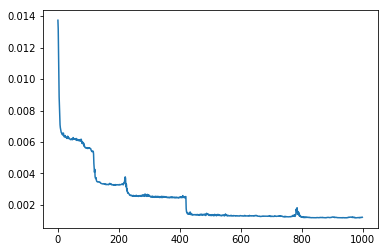

In [36]:
# using Adam with learning rat .001 keeping everything else default.
neural_network = NeuralNetwork().cuda()
loss_function= nn.MSELoss()
para = neural_network.parameters()
optimizer = torch.optim.Adam(params=para, lr=0.001)
loss_list = []
epochs = 1000
for i in range(epochs):
    input_iter = iter(train_loader)
    target_iter = iter(test_loader)
    while True:
        try:
            input_set = input_iter.next()
            target_set = target_iter.next()
            input_set = input_set.cuda()
            target_set = target_set.cuda()
            optimizer.zero_grad()
            network_output  = neural_network(input_set)
            loss = loss_function(network_output , target_set)
            loss.backward()
            optimizer.step()
        except StopIteration:
            break
    loss_list.append(loss.data.cpu().numpy())
print(loss.data)
plt.plot(range(epochs), loss_list)
plt.show()   

In [37]:
def test_audio(input_file_path, output_file_path):
    st, sr=librosa.load(input_file_path, sr=None)
    test = librosa.stft(st, n_fft=1024, hop_length=512)
    test_abs = torch.tensor(np.abs(test))
    test_abs = np.transpose(test_abs)
    test_loader = torch.utils.data.DataLoader(test_abs, batch_size=test_abs.shape[0])
    t_iter = iter(test_loader)
    with torch.no_grad():
        while True:
            try:
                data = t_iter.next()
                data = data.cuda()
                output = neural_network(data)
            except StopIteration:
                break 
        spec = (test / np.abs(test)) * output.cpu().numpy().T
        spec_istft = librosa.istft(spec, hop_length=512)
        librosa.output.write_wav(output_file_path, spec_istft, sr)

In [38]:
# testing on the audio 1
test_audio('data/test_x_01.wav', 'test_s_01_recons.wav')

In [39]:
ipd.Audio('test_s_01_recons.wav')